# ESML - accelerator

## PROJECT + DATA CONCEPTS + ENTERPRISE Datalake Design + DEV->PROD MLOps
- `1)ESML Project`: The ONLY thing you need to remember is your `Project number` (and `BRONZE, SILVER, GOLD` concept )
    - ProjectNo=4 have a list of all your datasets as ESMLDatasets. (Well you need to provide names for them also: "mydata01", "mydata02" - but thats it)
- `2)AutoLake - lakedesign & Roles`: Bronze, silver, gold + IN and date folders
    - Benefits: Physical datalake design!  onnected to Azure ML Workspace, with autoregistration of `Azure ML Datasets`
    - `Role 1`: `Data ingestion team` only need to care about 1 thing - onboard data to `IN-folder`, in .CSV format
        - `Auto parquet-conversion` from `IN` folder (.CSV) to `OUT`/BRONZE/bronze.PARQUET 
    - `Role 2`: `Data scientists` only need to care about 3 things (R/W): `BRONZE, SILVER, GOLD` datasets, all in .PARQUET format
    - How? The ESML project will `Automap` and `Autoregister` Azure ML Datasets - `IN, SILVER, BRONZE, GOLD`
- `2a) R&D  VS Production phase`: "Latest data" VS versioning on Datasets and datefolders  
    - Benefits "R&D mode": Faster RnD phase to onboard and refresh data easy. Also fast "flip-switch" to production
    - How? `ESMLDataset is context self aware` - knows when it is used in TRAIN or INFERENCE pipeline
- `2b) TRAIN vs INFERENCE` versions</u> `Reuse (Bronze->Silver->Gold) pipepline`, for both TRAIN preprocessing, and INFERENCE 
    - Benefits: Inference with different MODEL version, on data from the same day/time, (to compare scoring etc)
    - How? ESMLDataset have context self awareness, and `knows WHERE and HOW to load/save data`
- `2c) BATCH CONFIG`: Turn on/off features on ALL datasets
    - Accelerate setup: `Datadrift, Time series traits, Smart noise, etc`
    - Share refined data back to its "origin/non-projectbased structure" easy: 
        - ESMLProject.ShareBack(ds.Silver)
    - How? ESMProject controls all ESMDatasets, in a uniform way
## ENTERPRISE Deployment of Models & Governance - MLOps  at scale
- `3) DEV->TEST-PROD` (configs, compute, performance)
    - ESML has config for 3 environemnts: Easy DEPLOY model across subscriptions and Azure ML Studio workspaces 
        - Save costs & time: 
            - `DEV` has cheaper compute performance for TRAIN and INFERENCE (batch, AKS)
            - `DEV` has Quick-debug ML training (fast training...VS good scoring in TEST and PROD)
        - How? ESML `AutoMLFactory` and `ComputeFactory`
         

### Q&A:
- Q: Is ESML Machine learning specific? If I only want to refine some data...for integration, or report? 
- A: You can use this for just data refinement also: `Bronze->Silver->Gold` refinement.
    - Benefits: Enterprise security, Read/write to datalake, easy to share refined data. 
    - Benefits: The tooling "glued togehter": Azure datafactory +  Azure Databricks (and Azure ML Studio pipelines if needed)



# Datalake design - convention

## Train model
1)Data ingestion team: Lands raw in-data, and transform to .parquet in bronze. (Not included in MLOps. Use "Azure data factory / Biztalk / Logic apps".
-  master/1_projects/project002/03_diabetes_model_reg/`train`/ds01_diabetes/`in`/`dev`/2020/01/01/

2) `Bronze->Silver->Gold`
-  projects/project002/03_diabetes_model_reg/`train`/ds01_diabetes/out/bronze/`dev`/
-  projects/project002/03_diabetes_model_reg/`train`/ds01_diabetes/out/silver/`dev`/
-  projects/project002/03_diabetes_model_reg/`train`/gold/dev/

## Inference: Batch scoring
1) Data ingestion
- master/1_projects/project002/03_diabetes_model_reg/`inference/1/`ds01_diabetes/in/`dev`/2020/01/01/

2) `Bronze->Silver->Gold`
- projects/project002/03_diabetes_model_reg/`inference/1/`ds01_diabetes/out/bronze/`dev`/
- projects/project002/03_diabetes_model_reg/`inference/1/`ds01_diabetes/out/silver/`dev`/
- projects/project002/03_diabetes_model_reg/`inference/1/`gold/`dev`/

Notes: Inference ONLINE scoring (AKS)
- `inference/1/` = Model version
- inference/1/ds01_diabetes/in/`dev`/2020/01/01/`17/30/58/00` Can be used for Online AKS scenario - save scoring history on blob storage, down to `millisecond` (ms)
    - Save individual calls as Guid.parquet in `17/30/58/00` folder
- Pipeline logic `Bronze->Silver->Gold` = Can be used for Online AKS scenario to process raw input before calling `model.predict()` in the [run(raw_data)] method

Q: `dev`, `test`,`prod` folders at the end? 
- A: We have these folders at the end, for customers that wants a slim solution/low-maintenance, with just 1 datalake instance, and not 3 storage accounts.
    - If you have 3 storage accounts, only 1 of these folders (dev in dev storage account) will have data at each storage account. 
        - Pro's: 
            - This alternative is more cost flexible. Example: You can have lower cost replication-settings on DEV storage account.
        - Con's: 
            - A bit more work to share data between projects. 
            - A bit more work to update datalake design.
    - Below all says `dev` folder. But `dev`can also be `test`,`prod`

Q2: Why not `dev`, `test`,`prod` folders at the the top, e.g. on root-folder or container? 
 - A: Separation of access RBAC. Granularity: project-based AND environment-based. And "optimizeing the tree" same as keeping datetimefolders at the end..where it can grow massively if fast frequency
     - Each project/models, should have access to only THEIR dev,test,prod data...not all projects goes to production either.


## 1) ESMLProject - Project number gives you "lake area" 
- Config? settings/project_specific/`lake_settings.json`
    - `in_folder_data, ProjectNumber, scoring_folder_date, inferenceModelVersion,`modelAlias`, *datasetFolderNames`
    - `modelAlias` can be iteration-based `M03`, and/or tied to a user-alias  `M01_joakim`. 
        - Purpose: UI info in Azure ML Studio to easily see which datasets belong to WHAT model (if multi-model approach in project)
    - `R&D phase vs Production`: Set on `ESMLProject.rnd=True` to avoid versioning 
    - Tran VS Inference? 
        - ESMLProject and ESMLDatasets are `context self aware` and will figure this out
        - You can score data on a date, with different model-versions. And retrain the model on other data at the same time
- Benefits: 
    - ESMLProject `Automaps` + `Autoregister` Azure ML Datasets as: `IN, SILVER, BRONZE, GOLD`
    - `ESMLDatasets` are `context aware`, will write to TRAIN or INFERERENCE structure, and `inferenceModelVersion` is involved here.
    
### TIP: How to know your ProjectNumber? Dataset names? Date folder?
- You need to provide projectnumber, and dataset folder names 
    - Tip: same names you gave data ingestion team, the folder-names for datasets in lake
- TRAIN: Choose data onboarding date-folder? 
    - Tip: Ask data ingestion team about datefolders "2020-01-01" under IN folder, and what environment you want your data to land (dev,test,prod)

# 1A) Connect to TEST - using Authentication (SP's needed in TEST Azure ML workspace keyvault)

In [1]:
import sys, os
import pandas as pd 
from azureml.core import Workspace
sys.path.append(os.path.abspath("../azure-enterprise-scale-ml/esml/common/"))  # NOQA: E402
from esml import ESMLDataset, ESMLProject
from azureml.core.authentication import InteractiveLoginAuthentication

p = ESMLProject() # 1) self-aware about its config sources,  p.dev_test_prod = "dev" # active environment (override config)

p.dev_test_prod = "test" 
auth = InteractiveLoginAuthentication(tenant_id = p.tenant)
ws, config_name = p.authenticate_workspace_and_write_config(auth)

print(ws.name) 
p.init(ws) # Init TEST

# Feture engineering: Bronze 2 Gold - working with Azure ML Datasets with Bronze, Silver, Gold concept
ds = p.DatasetByName("ds01_diabetes") # 
df = ds.Silver.to_pandas_dataframe()
df_filtered = df[df.AGE > 0.015] 
gold_train = p.save_gold(df_filtered)


msft-weu-TEST-eap-proj02_ai-amls
...
....
Using GEN2 as Datastore
ds01_diabetes
..
ds02_other

####### Automap & Autoregister - SUCCESS!
1) Auto mapped 2 ESML Dataset with registered Azure ML Datasets (potentially all 3: IN,BRONZE, SILVER) in Datastore project002lake 

Dataset 'ds01_diabetes' status:
 - IN_Folder_has_files
 - BRONZE_Folder_has_files
 - SILVER_Folder_has_files
Dataset 'ds02_other' status:
 - BRONZE_Folder_has_files
 - SILVER_Folder_has_files

2) Registered each Dataset with suffixes (_IN_CSV, _BRONZE, _SILVER) 
 Tip: Use ESMLProject.Datasets list or .DatasetByName(myDatasetName) to read/write
#######
..


# 1B) Connect to TEST - via DEV workspae (prereq: datastore for TEST is needed)

In [2]:
import sys, os
import pandas as pd 
from azureml.core import Workspace
sys.path.append(os.path.abspath("../azure-enterprise-scale-ml/esml/common/"))  # NOQA: E402
from esml import ESMLDataset, ESMLProject
from azureml.core.authentication import InteractiveLoginAuthentication

p = ESMLProject() # 1) self-aware about its config sources,  p.dev_test_prod = "dev" # active environment (override config)
print(p.dev_test_prod) # DEV
p.ws = p.get_workspace_from_config() #2) Get DEV. Then Load TEST via DEV
print(p.ws.name)

#p.dev_test_prod = "test" # does this work? Yes
test_ws = p.get_other_workspace("test") # Get TEST via DEV workspace/keyvault via Service Principle
p.dev_test_prod = "test" # Works
p.init(test_ws) # Automapping from datalake to Azure ML datasets, prints status)
p.describe()

# Feture engineering: Bronze 2 Gold - working with Azure ML Datasets with Bronze, Silver, Gold concept

ds = p.DatasetByName("ds01_diabetes") # 
df = ds.Silver.to_pandas_dataframe()
df_filtered = df[df.AGE > 0.015] 
gold_train = p.save_gold(df_filtered)


dev
msft-weu-DEV-eap-proj02_ai-amls
...
Using GEN2 as Datastore
ds01_diabetes
ds02_other

####### Automap & Autoregister - SUCCESS!
1) Auto mapped 2 ESML Dataset with registered Azure ML Datasets (potentially all 3: IN,BRONZE, SILVER) in Datastore project002lake 

Dataset 'ds01_diabetes' status:
 - IN_Folder_has_files
 - BRONZE_Folder_has_files
 - SILVER_Folder_has_files
Dataset 'ds02_other' status:
 - BRONZE_Folder_has_files
 - SILVER_Folder_has_files

2) Registered each Dataset with suffixes (_IN_CSV, _BRONZE, _SILVER) 
 Tip: Use ESMLProject.Datasets list or .DatasetByName(myDatasetName) to read/write
#######
Training

 - ds01_diabetes
master/1_projects/project002/03_diabetes_model_reg/train/ds01_diabetes/in/test/2020/01/01/
master/1_projects/project002/03_diabetes_model_reg/train/ds01_diabetes/out/bronze/dev/
master/1_projects/project002/03_diabetes_model_reg/train/ds01_diabetes/out/silver/dev/

 - ds02_other
master/1_projects/project002/03_diabetes_model_reg/train/ds02_other/in/tes

## Alt 1) Empty constructor - auto-read your SETTINGS

In [3]:
import datetime
sys.path.append(os.path.abspath("../azure-enterprise-scale-ml/esml/common/"))  # NOQA: E402
from esml import ESMLDataset, ESMLProject

p = ESMLProject() # self-aware about its config sources
p.describe()

Training

 - ds01_diabetes
master/1_projects/project002/03_diabetes_model_reg/train/ds01_diabetes/in/dev/2020/01/01/
master/1_projects/project002/03_diabetes_model_reg/train/ds01_diabetes/out/bronze/dev/
master/1_projects/project002/03_diabetes_model_reg/train/ds01_diabetes/out/silver/dev/

 - ds02_other
master/1_projects/project002/03_diabetes_model_reg/train/ds02_other/in/dev/2020/01/01/
master/1_projects/project002/03_diabetes_model_reg/train/ds02_other/out/bronze/dev/
master/1_projects/project002/03_diabetes_model_reg/train/ds02_other/out/silver/dev/
Training GOLD 

master/1_projects/project002/03_diabetes_model_reg/train/gold/dev/
 

ENVIRONMENT - DEV, TEST, or PROD?
ACTIVE ENVIRONMENT = dev
ACTIVE subscription = ca0a8c40-b06a-4e4e-8434-63c03a1dee34
- MSFT-WEU-EAP_PROJECT02_AI-DEV-RG
- msft-weu-DEV-eap-proj02_ai-amls
- westeurope
- MSFT-WEU-EAP_CMN_AI-DEV-RG
- msft-weu-dev-cmnai-vnet
- msft-weu-dev-cmnai-sn-aml


# Great! Thats your ESML datalake area & environements (string generation from config)
## Now - involve Azure dependency: Automatically generate Datastore and Datasets

In [7]:
#### NB! This is needed only 1st time
from azureml.core import Workspace
from azureml.core.authentication import InteractiveLoginAuthentication

auth = InteractiveLoginAuthentication(tenant_id = p.tenant)
ws, config_name = p.authenticate_workspace_and_write_config(auth)
#### After that, you can use 'ws = p.get_workspace_from_config()'

# 2) ESML will Automap and Autoregister Azure ML Datasets - IN, SILVER, BRONZE, GOLD
- `Automap` and `Autoregister` Azure ML Datasets as: `IN, SILVER, BRONZE, GOLD`

In [8]:
from azureml.core import Workspace
ws = p.get_workspace_from_config()
ws.name

'msft-weu-DEV-eap-proj02_ai-amls'

In [9]:
datastore = p.init(ws)

...
Using GEN2 as Datastore
ds01_diabetes
ds02_other

####### Automap & Autoregister - SUCCESS!
1) Auto mapped 2 ESML Dataset with registered Azure ML Datasets (potentially all 3: IN,BRONZE, SILVER) in Datastore project002lake 

Dataset 'ds01_diabetes' status:
 - IN_Folder_has_files
 - BRONZE_Folder_has_files
 - SILVER_Folder_has_files
Dataset 'ds02_other' status:
 - IN_Folder_has_files
 - BRONZE_Folder_has_files
 - SILVER_Folder_has_files

2) Registered each Dataset with suffixes (_IN_CSV, _BRONZE, _SILVER) 
 Tip: Use ESMLProject.Datasets list or .DatasetByName(myDatasetName) to read/write
#######


In [10]:
ds_other = p.Datasets[1]
ds_other = p.DatasetByName("ds02_other")
print(ds_other.InData.name)
print(ds_other.Bronze.name)
print(ds_other.Silver.name)
#print(p.Gold.name) #  No data yet

M03_ds02_other_IN_CSV
M03_ds02_other_BRONZE
M03_ds02_other_SILVER


# 3) IN->`BRONZE->SILVER`->Gold
- Create dataset from PANDAS - Save to SILVER

In [11]:
import pandas as pd 
ds = p.DatasetByName("ds01_diabetes")
df = ds.Bronze.to_pandas_dataframe()
df.head()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


## 3) BRONZE-SILVER (EDIT rows & SAVE)
- Test change rows, same structure = new version (and new file added)
- Note: not earlier files in folder are removed. They are needed for other "versions". 
- Expected: For 3 files: New version, 997 rows: 2 older files=627 + 1 new file=370
- Expected (if we delete OLD files): New version, with less rows. 370 instead of 997

In [12]:
df_filtered = df[df.AGE > 0.015]
print(df.shape[0], df_filtered.shape[0])

442 185


## 3a) Save `SILVER` ds01_diabetes

In [13]:
aml_silver = p.save_silver(p.DatasetByName("ds01_diabetes"),df_filtered)
aml_silver.name

..


'M03_ds01_diabetes_SILVER'

### COMPARE `BRONZE vs SILVER`
- Compare and validate the feature engineering

In [14]:
ds01 = p.DatasetByName("ds01_diabetes")
bronze_rows = ds01.Bronze.to_pandas_dataframe().shape[0]
silver_rows = ds01.Silver.to_pandas_dataframe().shape[0]

print("Bronze: {}".format(bronze_rows)) # Expected 442 rows
print("Silver: {}".format(silver_rows)) # Expected 185 rows (filtered)

assert bronze_rows == 442,"BRONZE Should have 442 rows to start with, but is {}".format(bronze_rows)
assert silver_rows == 185,"SILVER should have 185 after filtering, but is {}".format(silver_rows)

Bronze: 442
Silver: 185


## 3b) Save  `BRONZE →  SILVER` ds02_other

In [15]:
df_edited = p.DatasetByName("ds02_other").Silver.to_pandas_dataframe()
ds02_silver = p.save_silver(p.DatasetByName("ds02_other"),df_edited)
ds02_silver.name

..


'M03_ds02_other_SILVER'

## 3c) Merge all `SILVERS -> SAVE to GOLD`
https://stackoverflow.com/questions/40468069/merge-two-dataframes-by-index
- pd.JOIN is a column-wise `left join`
    - df1.join(df2)
- pd.MERGE is a column-wise `inner join`
    - When to use: concatenating by `custom fields / indexes`
    - pd.merge(df1, df2, left_index=True, right_index=True) 
    - `join by: df1.col1 == df2.index`
        - pd.merge(df1, df2, left_on='col1' right_index=True)
    -  `join by _common_ columns`: `col1`, `col3`
        - pd.merge(df1, df2, on=['col1','col3']) 
- pd.CONCAT is a `ROW`-wise `outer join`
    - When to use? To contact 2-M dataframes `aligned by index`
    - pd.concat([df1, df2], axis=1)

In [16]:
df_01 = ds01.Silver.to_pandas_dataframe()
df_02 = ds02_silver.to_pandas_dataframe()

# 1) LEFT join
df_gold1_join = df_01.join(df_02) # left join -> NULL on df_02

# Alternative JOINS:

# 2) outer join -> NULL on both sides
df_gold2_concat = pd.concat([df_01, df_02], axis=1) # outer join -> NULL on both sides

# 3) # inner join -> no nulls
df_gold3_merged = df_01.merge(df_02,how="left", left_on="Y", right_on="Age", indicator="indicator_column") 
df_gold4_mergd = df_01.merge(df_02, left_index=True, right_index=True) # inner join -> no nulls

In [17]:
print("Diabetes shape: ", df_01.shape)
print(df_gold1_join.shape)
print(df_gold2_concat.shape)
print(df_gold3_merged.shape)
print(df_gold4_mergd.shape)

Diabetes shape:  (185, 11)
(185, 19)
(887, 19)
(248, 20)
(185, 19)


# Save `GOLD` v1

In [17]:
print(p.rnd)

False


In [18]:
p.rnd=False

In [18]:
ds_gold_v1 = p.save_gold(df_gold1_join)

### 3c) Ops! "faulty" GOLD - too many features

In [19]:
print(p.Gold.to_pandas_dataframe().shape)

(185, 19)


In [20]:
print("Are we in RnD phase? Or do we have 'versioning on datasets=ON'")
print("RnD phase = {}".format(p.rnd))

Are we in RnD phase? Or do we have 'versioning on datasets=ON'
RnD phase = False


# Save `GOLD` v2

In [37]:
# Lets just go with features from ds01
ds_gold_v1 = p.save_gold(df_01)

# Split `GOLD` into 3 - `train, validate, test`


In [ ]:
label = "Y"
train_6, validate_set_2, test_set_2 = p.split_gold_3(0.6, label) 
print(" - Q:Why add LABEL info when splitting for TRAIN? For future sake...VALIDATE, TEST")

In [ ]:
print("...This is why:")
X_test, y_test, tags = p.get_gold_validate_Xy() # Version is default latest
print(tags)

# Get `GOLD` by version

In [ ]:
gold_1 = p.get_gold_version(1)
gold_1.to_pandas_dataframe().shape # (185, 19)

In [ ]:
gold_2 = p.get_gold_version(2)
gold_2.to_pandas_dataframe().shape # (185, 11)

In [ ]:
p.Gold.to_pandas_dataframe().shape # Latest version (185, 11)

In [ ]:
new_project = ESMLProject()
new_project.init(ws)

In [ ]:
gold_1 = new_project.get_gold_version(1)
print(gold_1.to_pandas_dataframe().shape) # (185, 19)

gold_2 = new_project.get_gold_version(2)
print(gold_2.to_pandas_dataframe().shape) # (185, 11)

print(new_project.Gold.to_pandas_dataframe().shape) # Latest(185, 11)

In [ ]:
gold_2

In [30]:
p.rnd = True
ds_gold_v1 = p.save_gold(df_01)
ds_gold_v1 = p.save_gold(df_01)
ds_gold_v1 = p.save_gold(df_gold1_join)

Since R&D setting - unregister dataset M03_GOLD, before register again
Since R&D setting - unregister dataset M03_GOLD, before register again
Since R&D setting - unregister dataset M03_GOLD, before register again


In [31]:
p.rnd = False
ds_gold_v1 = p.save_gold_pandas_as_azure_dataset(df_gold1_join) # v2
ds_gold_v1 = p.save_gold_pandas_as_azure_dataset(df_01)
ds_gold_v1 = p.save_gold_pandas_as_azure_dataset(df_gold1_join)

# Slice `ROWS` and create filtered version

In [32]:
df_01_filtered = df_01[df_01.AGE > 0.03807]
ds_gold_v1 = p.save_gold(df_01_filtered)

# Look at ds_02 - Titanic

In [33]:
df_02.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


<AxesSubplot:>

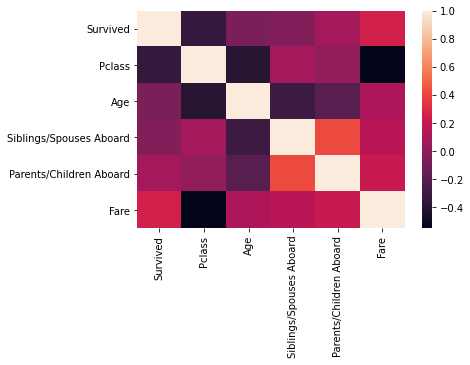

In [35]:
import seaborn as sns
corr = df_02.corr() # print(corr)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)